In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil
import numpy as np
from scipy import stats
from tqdm import tqdm
from IPython.display import clear_output

import py21cmfish
from py21cmfish.power_spectra import *
from py21cmfish.io import *

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## 1. 21cmFISH standard astrophysics

In [2]:
noise_dir = '/n/home07/yitians/dm21cm/21cmSense_fid_EOS21/'
data_dir = '/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/bkg/LightCones/'


astro_params_vary = ['DM', 'F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR',
                     'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'A_LW']
default_param_values = [0, -1.25, -2.5, 0.5, 0.0, 0.5, -1.35, -1.35, -0.3, 40.5, 40.5, 500, 2.0]

astro_params_vary = list(np.array(astro_params_vary))
default_param_values = default_param_values
astro_params_fid = dict()
for i in range(len(astro_params_vary)):
    astro_params_fid[astro_params_vary[i]] = default_param_values[i]
    
# Load each parameter into a dictionary
params_EoS = {}

for param in astro_params_vary[1:]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir = data_dir,
        PS_err_dir = noise_dir,
        new = False
)
clear_output()

## 2. Fisher analysis at each mass

In [8]:
from preprocessing.step_size import pbh_f
log10m_s = np.insert(np.arange(13.25, 18+0.001, 0.25), 0, 13.20)
m_PBH_s = 10 ** log10m_s # [g]
f_PBH_s = pbh_f(m_PBH_s) # [1]
run_name = 'pbh-fine'
print(log10m_s)
print(f_PBH_s)

mass_s = m_PBH_s
inj_s = f_PBH_s

[13.2  13.25 13.5  13.75 14.   14.25 14.5  14.75 15.   15.25 15.5  15.75
 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75 18.  ]
[2.51188643e-10 1.00000000e-10 1.00000000e-12 2.46619009e-14
 1.61695617e-14 7.49894209e-14 5.62341325e-13 4.21696503e-12
 3.16227766e-11 2.37137371e-10 1.77827941e-09 1.33352143e-08
 1.00000000e-07 7.49894209e-07 5.62341325e-06 4.21696503e-05
 3.16227766e-04 2.37137371e-03 1.77827941e-02 1.33352143e-01
 1.00000000e+00]


In [28]:
from preprocessing.step_size import pwave_phot_c_sigma, pwave_elec_c_sigma
# m_s = 10**np.array([1.5, 12])
# c_s = pwave_phot_c_sigma(m_s)
# run_name = 'pwave-phot-test'
m_s = 10**np.array([6.5, 8.5, 10.5, 12])
c_s = pwave_elec_c_sigma(m_s)
run_name = 'pwave-elec-test'
print(c_s)

mass_s = m_s
inj_s = c_s

[1.77827941e-23 1.77827941e-20 1.77827941e-17 3.16227766e-15]


In [29]:
inj_dir = f'/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/{run_name}'
os.listdir(inj_dir)

['log10m12.000', 'log10m6.500', 'log10m8.500', 'log10m10.500']

In [30]:
# Gotta put the fiducial lightcone in each mass directory
for m in mass_s:
    source_file = f'{data_dir}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    target_file = f'{inj_dir}/log10m{np.log10(m):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    if not os.path.isfile(target_file):
        print(f'{np.log10(m):.3f}', end=' ')
        shutil.copyfile(source_file, target_file)

In [ ]:
sigma_s = []
force_new = True

for m in mass_s:
    print(f'\n\nNow processing m={m:.3e}\n\n')

    lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
    new = ('lc_redshifts.npy' not in os.listdir(lc_dir)) or force_new
    
    for param in astro_params_vary[:1]:
        params_EoS[param] = py21cmfish.Parameter(
            HII_DIM=128, BOX_LEN=256, param=param,
            output_dir=lc_dir,
            PS_err_dir=noise_dir, new=new,
        )

    Fij_matrix_PS, Finv_PS= py21cmfish.make_fisher_matrix(
        params_EoS,
        fisher_params=astro_params_vary,
        hpeak=0.0, obs='PS',
        k_min=0.1, k_max=1,
        sigma_mod_frac=0.2,
        add_sigma_poisson=True
    )
    sigma_s.append(np.sqrt(Finv_PS[0, 0]))
    
sigma_s = np.array(sigma_s)

[None, None]

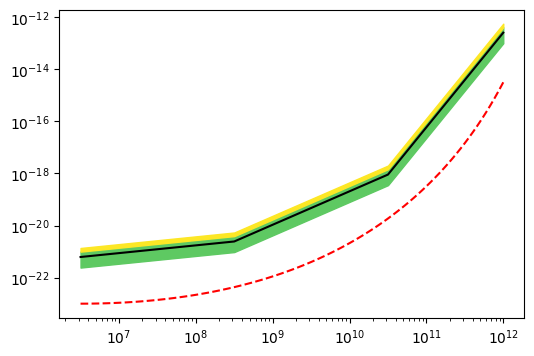

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

ax.plot(mass_s, upper_limit, 'k')
ax.fill_between(mass_s, upper_limit + one_sigma, upper_limit - one_sigma, color=mpl.colormaps['viridis'](0.75))
ax.fill_between(mass_s, upper_limit + 2*one_sigma, upper_limit + one_sigma, color=mpl.colormaps['viridis'](1.0))

m_s = np.logspace(6.5, 12, 100)
ax.plot(m_s, pwave_elec_c_sigma(m_s), 'r--')

ax.set(xscale='log', yscale='log')
#ax.set(xlabel=r'$M$ [g]', ylabel=r'$f$')

In [24]:
from preprocessing.step_size import pwave_phot_c_sigma

In [25]:
pwave_phot_c_sigma(1e12)

7.943282347242822e-13

In [22]:
np.log10(8e-13)

-12.096910013008056

In [ ]:
pwave_phot_c_sigma(1e12)

7.943282347242822e-13

In [14]:
np.savetxt('../outputs/limits/pbh_limits.txt', np.array([mass_s, inj_s, sigma_s]).T, header='mass_s inj_s sigma_s')